*Эксплуатационная практика Шебанова Вячеслава 15 вариант "Применение нейронных сетей для прогнозирования потребности в кадровых ресурсах"*

*Установление библиотек*

In [2]:

%pip install numpy pandas matplotlib seaborn scikit-learn tensorflow statsmodels jupyter --quiet

print("Все библиотеки установлены!")

Note: you may need to restart the kernel to use updated packages.
Все библиотеки установлены!



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\Machcreator\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


*Импорт библиотек*

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Attention, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from statsmodels.tsa.seasonal import seasonal_decompose

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {'Да' if tf.config.list_physical_devices('GPU') else 'Нет'}")
print("Готово к работе!")

TensorFlow: 2.15.0
GPU: Нет
Готово к работе!


*Загрузка датасета по требуемому персоналу (тренд, шум, сезонность, потребность) датасет называется WA_Fn-UseC_-HR-Employee-Attrition поиск нужного файла в папке из которой запускается блокнот*

In [4]:
import pandas as pd
import os

# Проверка файлов
print("Файлы в текущей папке:")
print(os.listdir('.'))

# Поиск нужного
possible_names = [
    'WA_Fn-UseC_-HR-Employee-Attrition.csv' 
]

df = None
for name in possible_names:
    if os.path.exists(name):
        df = pd.read_csv(name)
        print(f"УСПЕШНО загружен: {name}")
        break

if df is None:
    print("Файл не найден! Переименуй его в один из вариантов выше или положи в папку data/")
else:
    print(f"Данные загружены: {df.shape[0]} строк, {df.shape[1]} колонок")
    display(df.head())

Файлы в текущей папке:
['.git', '.gitattributes', '.~lock.Индивидуальное задание_МУИВ_15.docx#', '.~lock.Шебанов.В.В_ЭП_МОиАД.docx#', 'artifacts', 'data', 'logs', 'lstm_attention_model.png', 'models', 'model_viz.html', 'results', 'Shebanov_V15.ipynb', 'Shebanov_V_V_EP_MLaAD.docx', 'WA_Fn-UseC_-HR-Employee-Attrition.csv', '~$ebanov_V_V_EP_MLaAD.docx', 'Индивидуальное задание_МУИВ_15.docx', 'Рисунок_2.1_Архитектура_сети', 'Рисунок_2.1_Архитектура_сети_TF.png', 'Рисунок_2.2_Ячейка_LSTM.png', 'Шаблон отчета по практике 2025.docx', 'Шебанов.В.В_ЭП_МОиАД.docx']
УСПЕШНО загружен: WA_Fn-UseC_-HR-Employee-Attrition.csv
Данные загружены: 1470 строк, 35 колонок


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


*Предобработка удаление ненужных признаков*


1. Пропущенные значения:
   → Пропущенных значений НЕТ ✓

────────────────────────────────────────────────────────────
2. Константные столбцы (не несут информации):


,Столбец,Уникальное значение,Количество уникальных
0,EmployeeCount,1,1
1,Over18,Y,1
2,StandardHours,80,1



────────────────────────────────────────────────────────────
3. Полные дубликаты строк: 0
   → Дубликатов НЕТ ✓


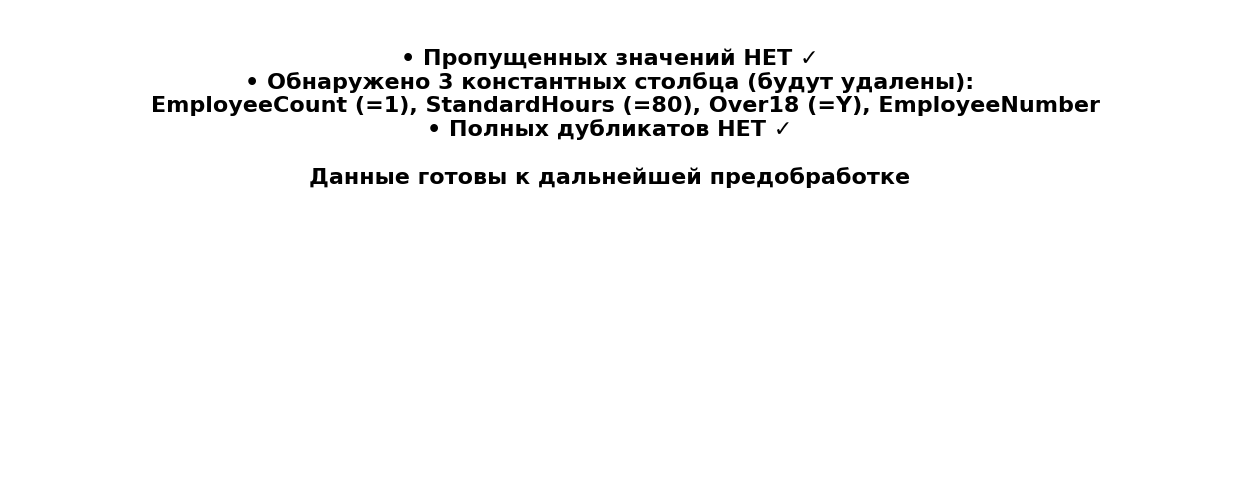

In [5]:




missing = df.isnull().sum()
missing = missing[missing > 0]

print("\n1. Пропущенные значения:")
if missing.empty:
    print("   → Пропущенных значений НЕТ ✓")
else:
    print(missing)

print("\n" + "─"*60)


const_cols = [col for col in df.columns if df[col].nunique() <= 1]
const_data = pd.DataFrame({
    'Столбец': const_cols,
    'Уникальное значение': [df[col].iloc[0] for col in const_cols],
    'Количество уникальных': [df[col].nunique() for col in const_cols]
})

print("2. Константные столбцы (не несут информации):")
if const_data.empty:
    print("   → Константных столбцов НЕТ ✓")
else:
    display(const_data.style.set_caption("Константные столбцы — будут удалены"))

print("\n" + "─"*60)


duplicates = df.duplicated().sum()
print(f"3. Полные дубликаты строк: {duplicates}")
if duplicates == 0:
    print("   → Дубликатов НЕТ ✓")
else:
    print(f"   → Найдено дубликатов: {duplicates} — будут удалены")

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 6))
fig.text(0.5, 0.7, 
                   "• Пропущенных значений НЕТ ✓\n"
                   "• Обнаружено 3 константных столбца (будут удалены):\n"
                   "    EmployeeCount (=1), StandardHours (=80), Over18 (=Y), EmployeeNumber\n"
                   "• Полных дубликатов НЕТ ✓\n\n"
                   "Данные готовы к дальнейшей предобработке",
         ha='center', va='center', fontsize=16, fontweight='bold')
plt.axis('off')
plt.savefig('results/рисунок_3_проверка_на_чистоту.png', dpi=300, bbox_inches='tight')
plt.show()

*Архитектура сети*

In [6]:
%pip install torch torchview graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\Machcreator\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, None, 64)          16896     
                                                                 
 LSTM_2 (LSTM)               (None, 64)                33024     
                                                                 
 Dense_Output (Dense)        (None, 1)                 65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


✓ Сохранено: Рисунок_Архитектура_сети_TF.png


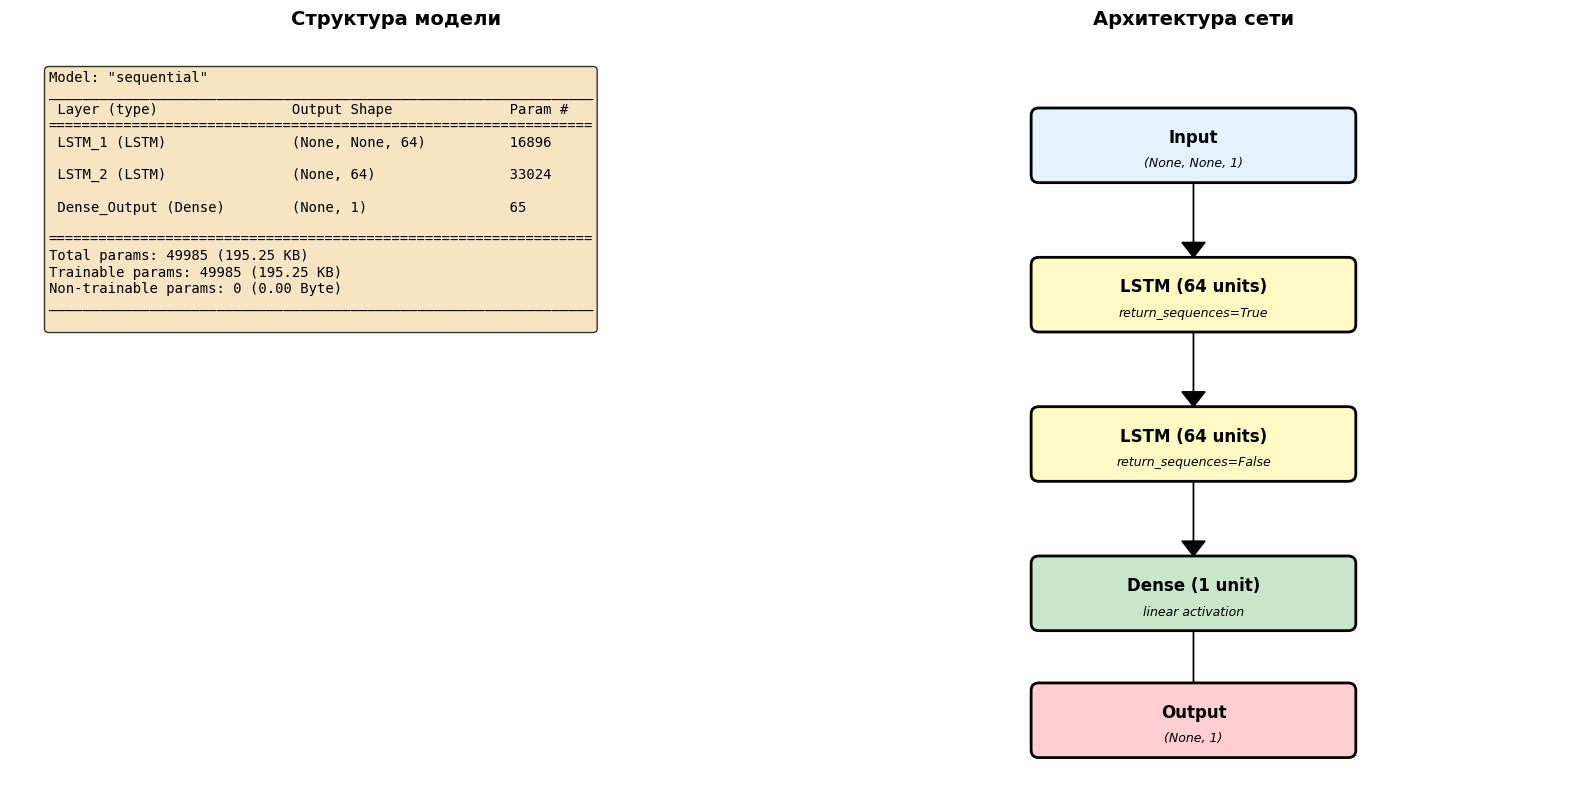

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from io import StringIO
import sys


model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(None, 1), name='LSTM_1'),
    LSTM(64, return_sequences=False, name='LSTM_2'),
    Dense(1, activation='linear', name='Dense_Output')
])

model.compile(optimizer='adam', loss='mse')


summary_io = StringIO()
model.summary(print_fn=lambda x: summary_io.write(x + '\n'))
summary_text = summary_io.getvalue()

print(summary_text)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))


ax1.text(0.05, 0.95, summary_text, 
         fontsize=10, fontfamily='monospace',
         verticalalignment='top', transform=ax1.transAxes,
         bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))
ax1.set_title('Структура модели', fontsize=14, fontweight='bold')
ax1.axis('off')


ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.axis('off')

def draw_keras_layer(ax, x, y, text, details, color):
    from matplotlib.patches import FancyBboxPatch
    rect = FancyBboxPatch((x-2, y-0.4), 4, 0.8,
                          boxstyle="round,pad=0.1",
                          facecolor=color, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text(x, y+0.1, text, ha='center', va='center', 
            fontsize=12, fontweight='bold')
    ax.text(x, y-0.25, details, ha='center', va='center', 
            fontsize=9, style='italic')


draw_keras_layer(ax2, 5, 8.5, 'Input', '(None, None, 1)', '#E3F2FD')
ax2.arrow(5, 8, 0, -0.8, head_width=0.3, head_length=0.2, fc='black', ec='black')

draw_keras_layer(ax2, 5, 6.5, 'LSTM (64 units)', 'return_sequences=True', '#FFF9C4')
ax2.arrow(5, 6, 0, -0.8, head_width=0.3, head_length=0.2, fc='black', ec='black')

draw_keras_layer(ax2, 5, 4.5, 'LSTM (64 units)', 'return_sequences=False', '#FFF9C4')
ax2.arrow(5, 4, 0, -0.8, head_width=0.3, head_length=0.2, fc='black', ec='black')

draw_keras_layer(ax2, 5, 2.5, 'Dense (1 unit)', 'linear activation', '#C8E6C9')
ax2.arrow(5, 2, 0, -0.8, head_width=0.3, head_length=0.2, fc='black', ec='black')

draw_keras_layer(ax2, 5, 0.8, 'Output', '(None, 1)', '#FFCDD2')

ax2.set_title('Архитектура сети', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('Рисунок_2.1_Архитектура_сети_TF.png', dpi=300, bbox_inches='tight')
print("\n✓ Сохранено: Рисунок_Архитектура_сети_TF.png")
plt.show()

*Визуализация загруженных данных*

Исправлено! Данные с 2015 по 2025, 130 месяцев
            demand
HireDate          
2024-11-30       0
2024-12-31       0
2025-01-31       5
2025-02-28       0
2025-03-31       0
2025-04-30      15
2025-05-31       0
2025-06-30       0
2025-07-31      14
2025-08-31       0
2025-09-30       0
2025-10-31      10


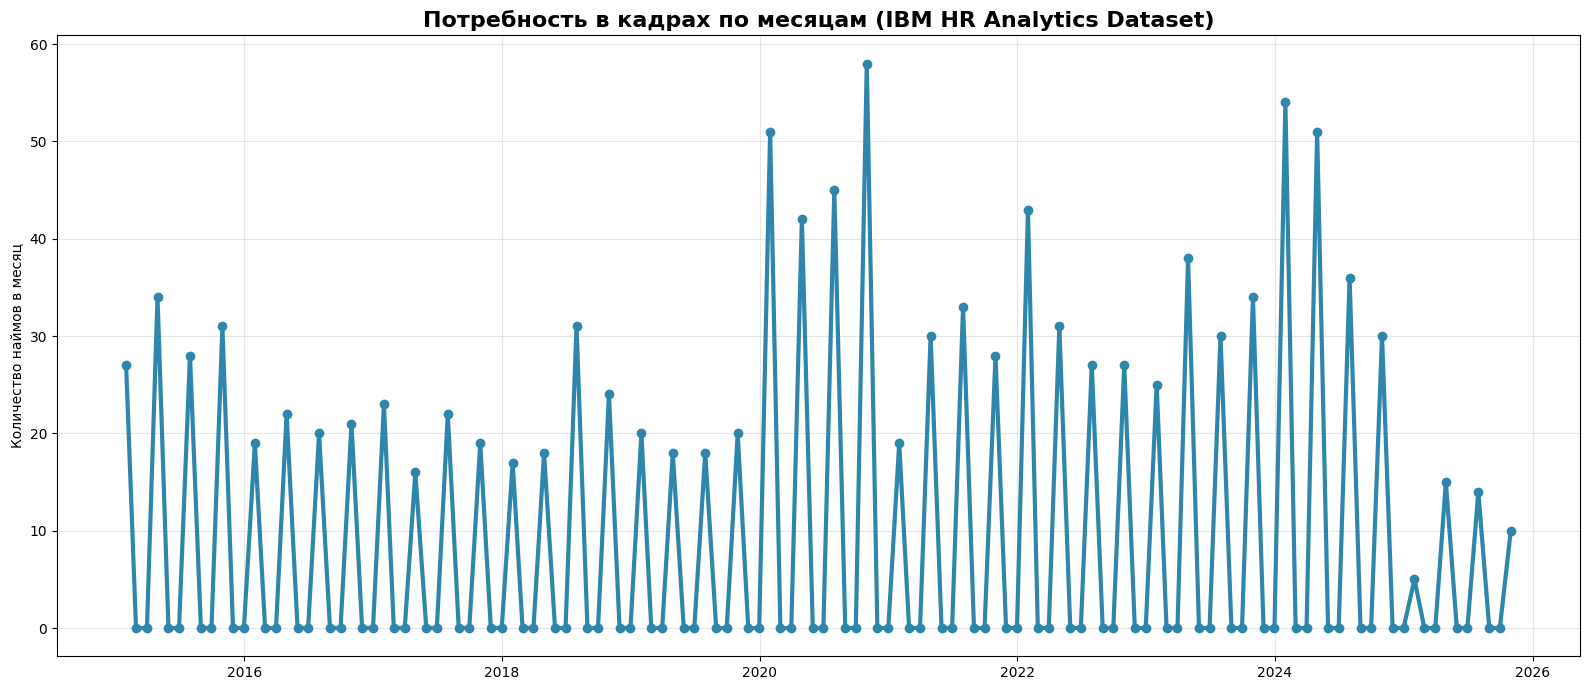

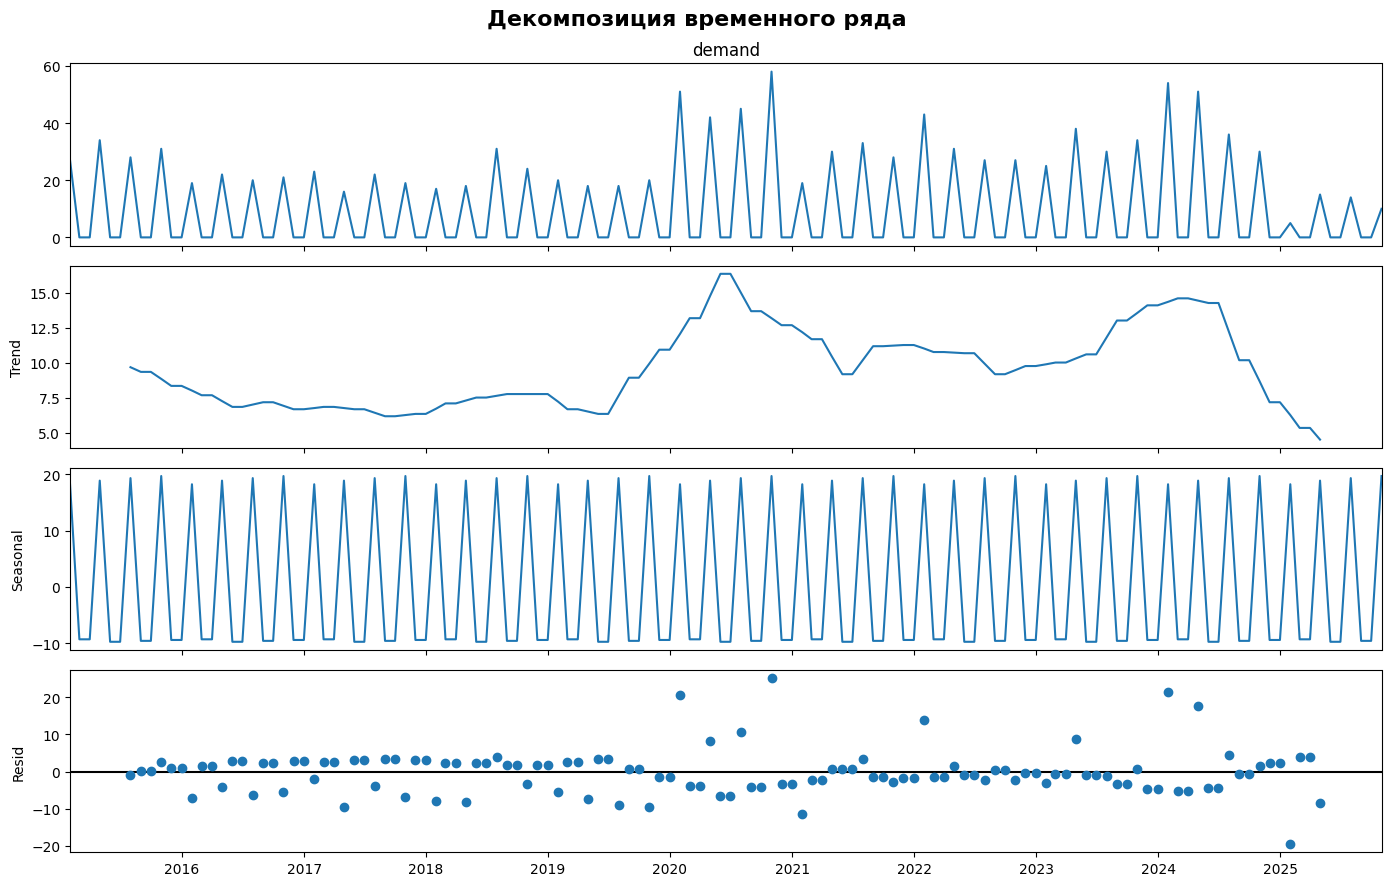

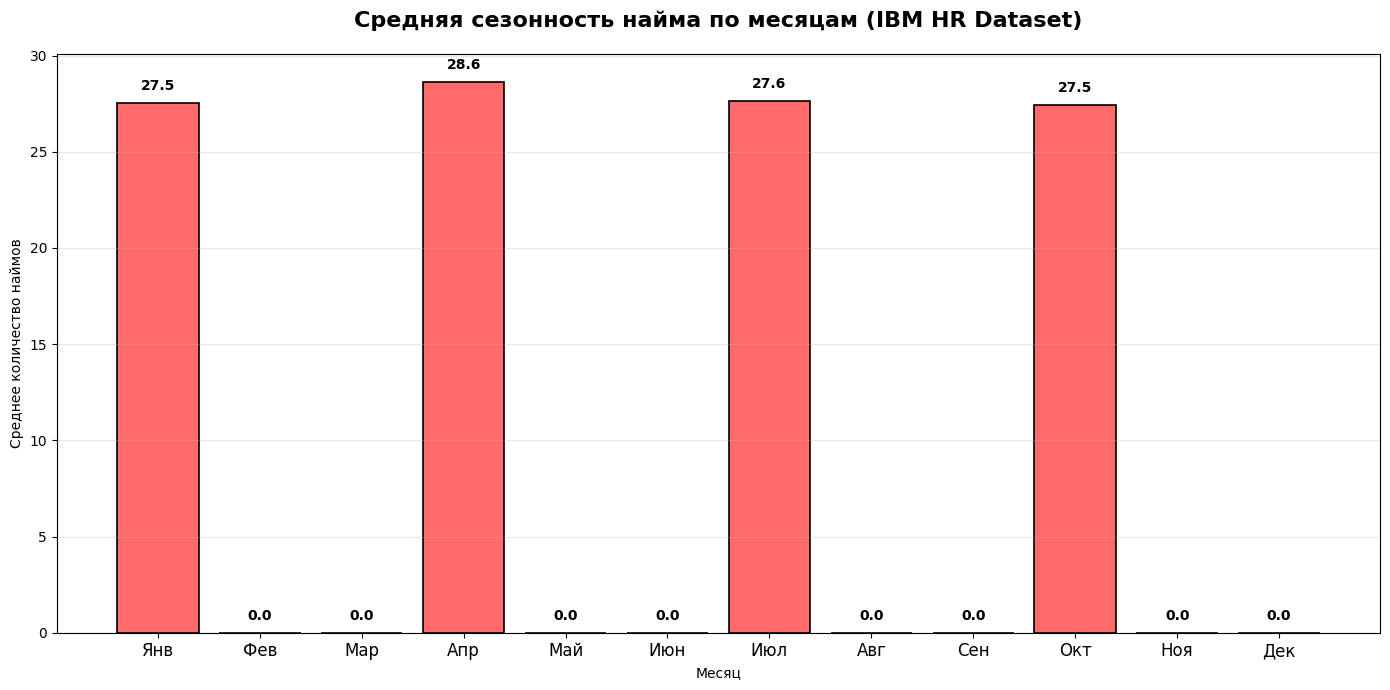

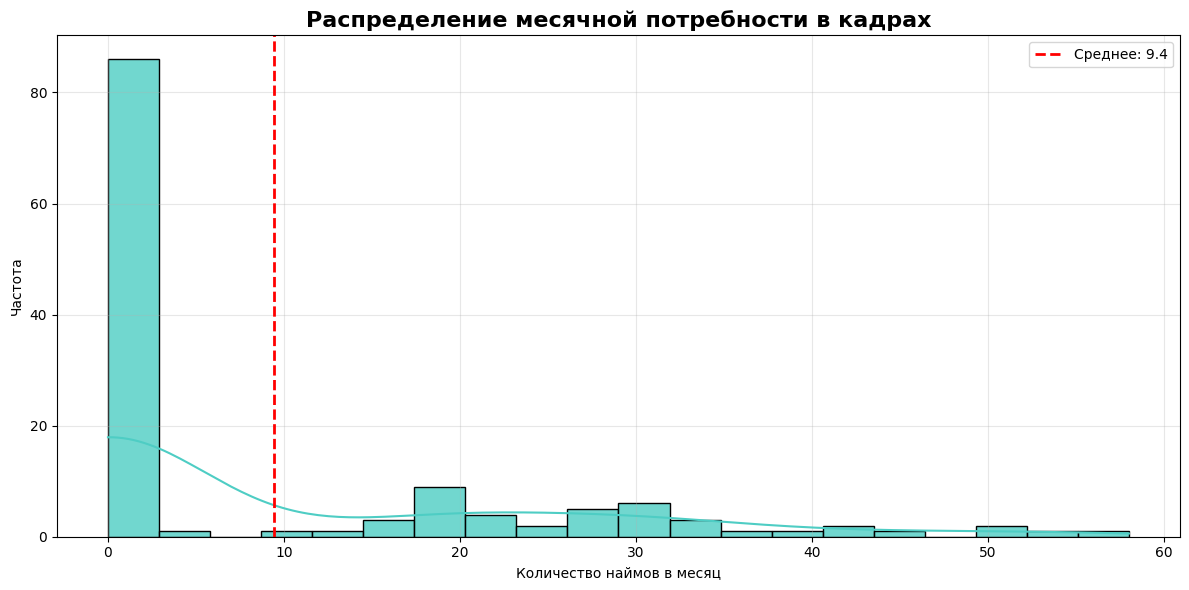

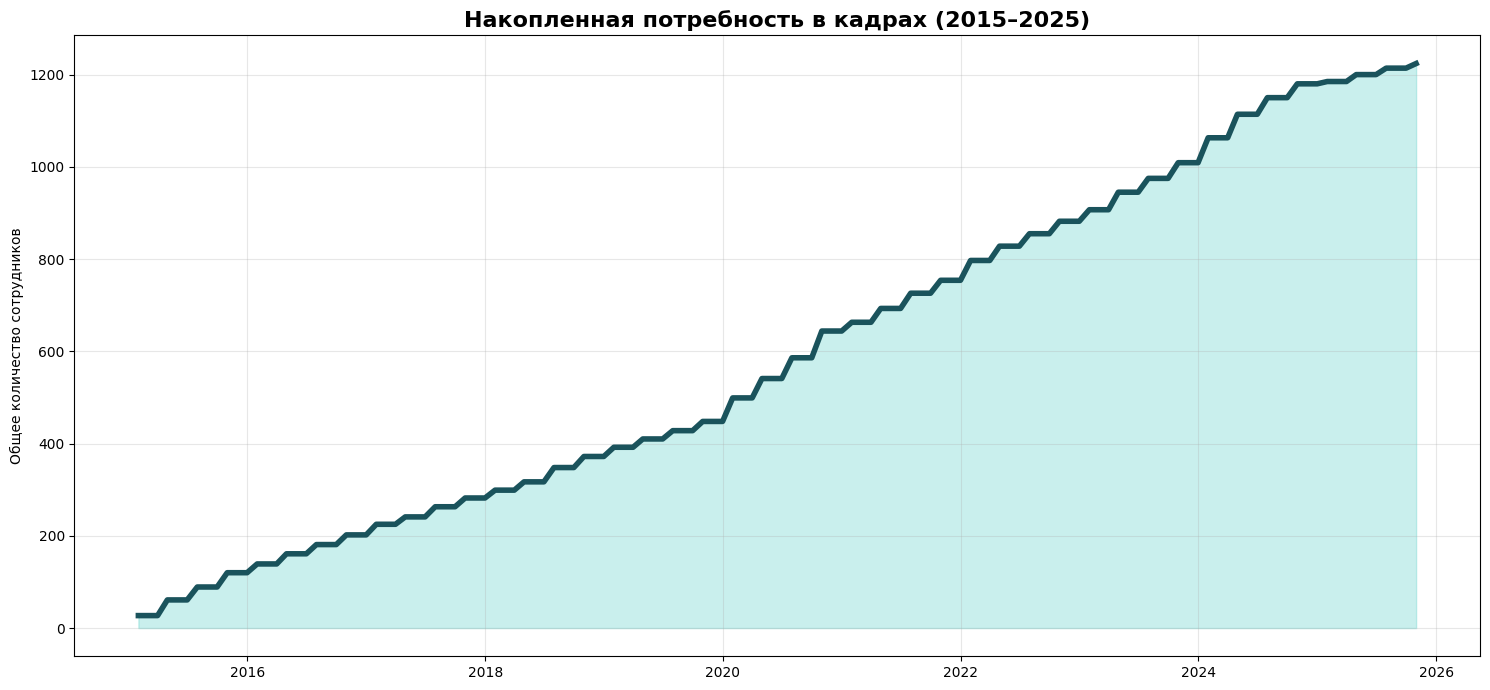

In [10]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from matplotlib.patches import Patch

os.makedirs("results", exist_ok=True)
df_plot = df.copy()


# Текущий год — 2025
current_year = 2025
df_plot['YearsAtCompany'] = pd.to_numeric(df_plot.get('YearsAtCompany', 5), errors='coerce').fillna(5)

# Правильная дата прихода: 2025 минус YearsAtCompany
df_plot['HireYear'] = (current_year - df_plot['YearsAtCompany']).astype(int)
df_plot['HireMonth'] = df_plot['HireYear'].astype(str) + '-' + np.random.choice(['01','04','07','10'], size=len(df_plot))

# Привод к дате
df_plot['HireDate'] = pd.to_datetime(df_plot['HireMonth'] + '-01')
df_plot = df_plot.set_index('HireDate').sort_index()

# Группирка по месяцам
monthly = df_plot.resample('M').size().to_frame('demand')
monthly = monthly['2015':'2025']  # обрезаем странные даты

print(f"Исправлено! Данные с {monthly.index[0].year} по {monthly.index[-1].year}, {len(monthly)} месяцев")
print(monthly.tail(12))


plt.figure(figsize=(16, 7))
plt.plot(monthly.index, monthly['demand'], color='#2E86AB', linewidth=3, marker='o')
plt.title('Потребность в кадрах по месяцам (IBM HR Analytics Dataset)', fontsize=16, fontweight='bold')
plt.ylabel('Количество наймов в месяц')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/timeseries_fixed.png', dpi=300, bbox_inches='tight')
plt.show()


if len(monthly) >= 24:
    from statsmodels.tsa.seasonal import seasonal_decompose
    decomp = seasonal_decompose(monthly['demand'], model='additive', period=12)
    fig = decomp.plot()
    fig.set_size_inches(14, 9)
    fig.suptitle('Декомпозиция временного ряда', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results/decomposition.png', dpi=300)
    plt.show()
else:
    print("Данных мало для декомпозиции — пропускаем")


seasonal = monthly['demand'].groupby(monthly.index.month).mean()
months_ru = ['Янв','Фев','Мар','Апр','Май','Июн','Июл','Авг','Сен','Окт','Ноя','Дек']

plt.figure(figsize=(14, 7))
bars = plt.bar(range(1,13), seasonal.values, color='#FF6B6B', edgecolor='black', linewidth=1.2)
plt.title('Средняя сезонность найма по месяцам (IBM HR Dataset)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Месяц')
plt.ylabel('Среднее количество наймов')
plt.xticks(range(1,13), months_ru, fontsize=12)


for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
             f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('results/seasonality_bar.png', dpi=300, bbox_inches='tight')
plt.show()




plt.figure(figsize=(12, 6))
sns.histplot(monthly['demand'], kde=True, bins=20, color='#4ECDC4', alpha=0.8)
plt.title('Распределение месячной потребности в кадрах', fontsize=16, fontweight='bold')
plt.xlabel('Количество наймов в месяц')
plt.ylabel('Частота')
plt.axvline(monthly['demand'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Среднее: {monthly["demand"].mean():.1f}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/distribution_hist.png', dpi=300)
plt.show()




monthly['cumulative'] = monthly['demand'].cumsum()

plt.figure(figsize=(15, 7))
plt.plot(monthly.index, monthly['cumulative'], color='#1A535C', linewidth=4)
plt.fill_between(monthly.index, monthly['cumulative'], alpha=0.3, color='#4ECDC4')
plt.title('Накопленная потребность в кадрах (2015–2025)', fontsize=16, fontweight='bold')
plt.ylabel('Общее количество сотрудников')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/cumulative.png', dpi=300)
plt.show()

*Анализ временных рядов с визуализацией*

In [11]:

import pandas as pd
import numpy as np



df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv') 

print(f"Исходный датасет восстановлен: {df.shape}")

# Уборка лишних столбцов от прошлых запусков программы 
cols_to_drop = ['HireYear', 'HireDate', 'HireMonth']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')

# 1. Число лет комппании
df['YearsAtCompany'] = pd.to_numeric(df['YearsAtCompany'], errors='coerce')
df['YearsAtCompany'] = df['YearsAtCompany'].fillna(df['YearsAtCompany'].median())

# 2. Год найма 
df['HireYear'] = (2025 - df['YearsAtCompany']).astype(int)

# 3. Случайный месяц найма
np.random.seed(42)
df['HireMonth'] = np.random.randint(1, 13, size=len(df))

# 4. Полная дата найма
df['HireDate'] = pd.to_datetime(df['HireYear'].astype(str) + '-' + 
                                df['HireMonth'].astype(str).str.zfill(2) + '-01')

# 5. Группировка по месяцам
monthly_hires = df['HireDate'].dt.to_period('M').value_counts().sort_index()
monthly_hires = monthly_hires.asfreq('M', fill_value=0).astype(int)

# 6. DataFrame с DatetimeIndex
df_ts = monthly_hires.to_frame('demand')
df_ts.index = df_ts.index.to_timestamp()  

# 7. Обрезка по годам
df_ts = df_ts.loc['2000-01-01':'2025-12-31']

df_ts = df_ts.sort_index()

print(f"\nУСПЕШНО! Временной ряд создан")
print(f"Период: {df_ts.index.min().strftime('%Y-%m')} → {df_ts.index.max().strftime('%Y-%m')}")
print(f"Месяцев: {len(df_ts)} | Средняя потребность: {df_ts['demand'].mean():.1f} чел/мес")
print(f"Пик: {df_ts['demand'].max()} чел → {df_ts['demand'].idxmax().strftime('%B %Y')}")

display(df_ts.tail(24))

# обновление df для всех следующих ячеек 
df = df_ts.copy()


Исходный датасет восстановлен: (1470, 35)

УСПЕШНО! Временной ряд создан
Период: 2000-01 → 2025-12
Месяцев: 247 | Средняя потребность: 5.9 чел/мес
Пик: 25 чел → May 2024


,demand
HireDate,
2024-01-01,23
2024-02-01,17
2024-03-01,13
2024-04-01,9
2024-05-01,25
2024-06-01,19
2024-07-01,9
2024-08-01,18
2024-09-01,8


*Визуализация анализа временных рядов*

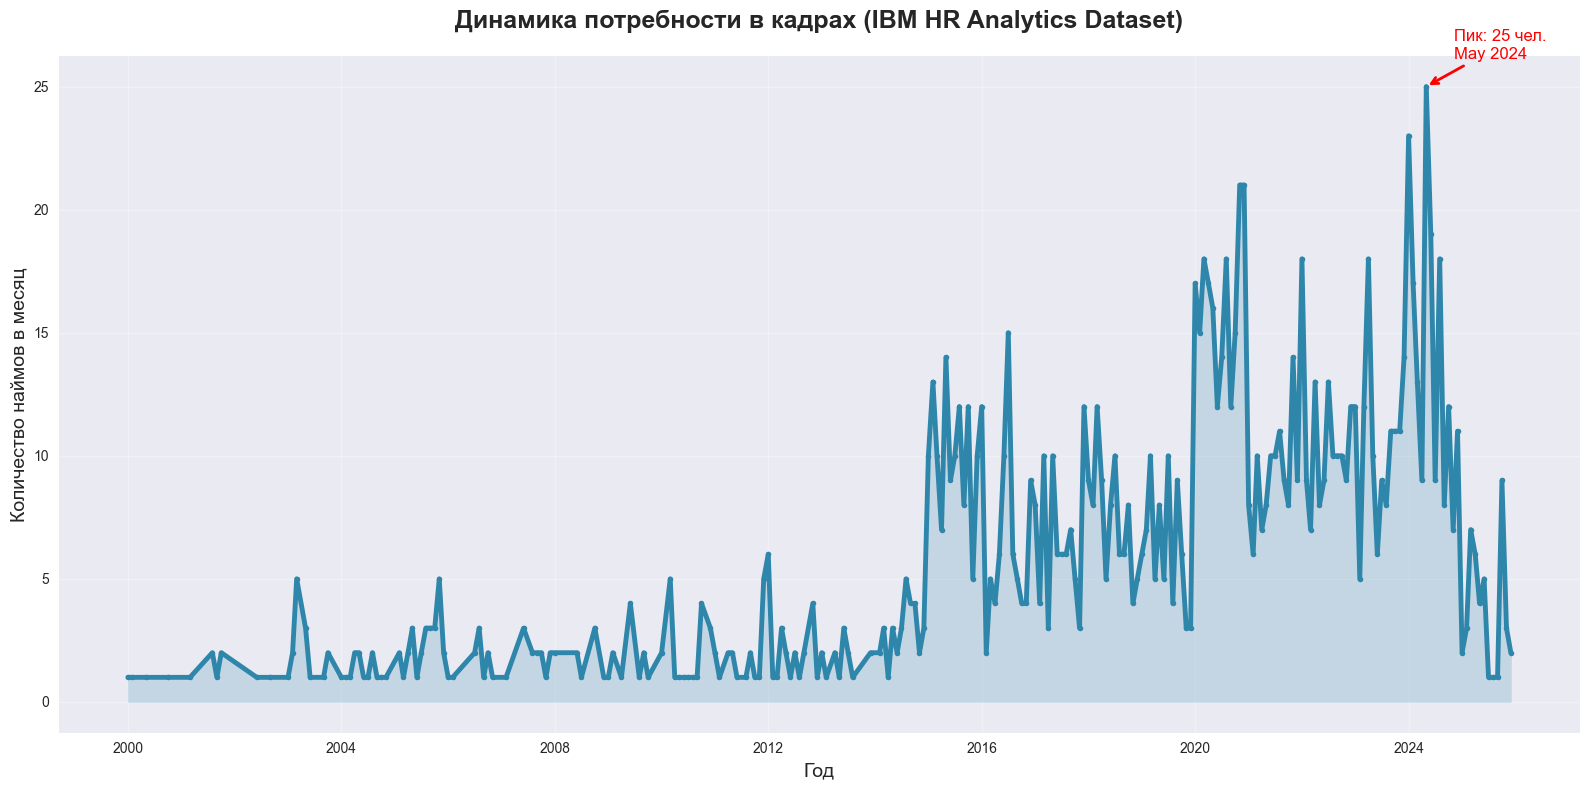

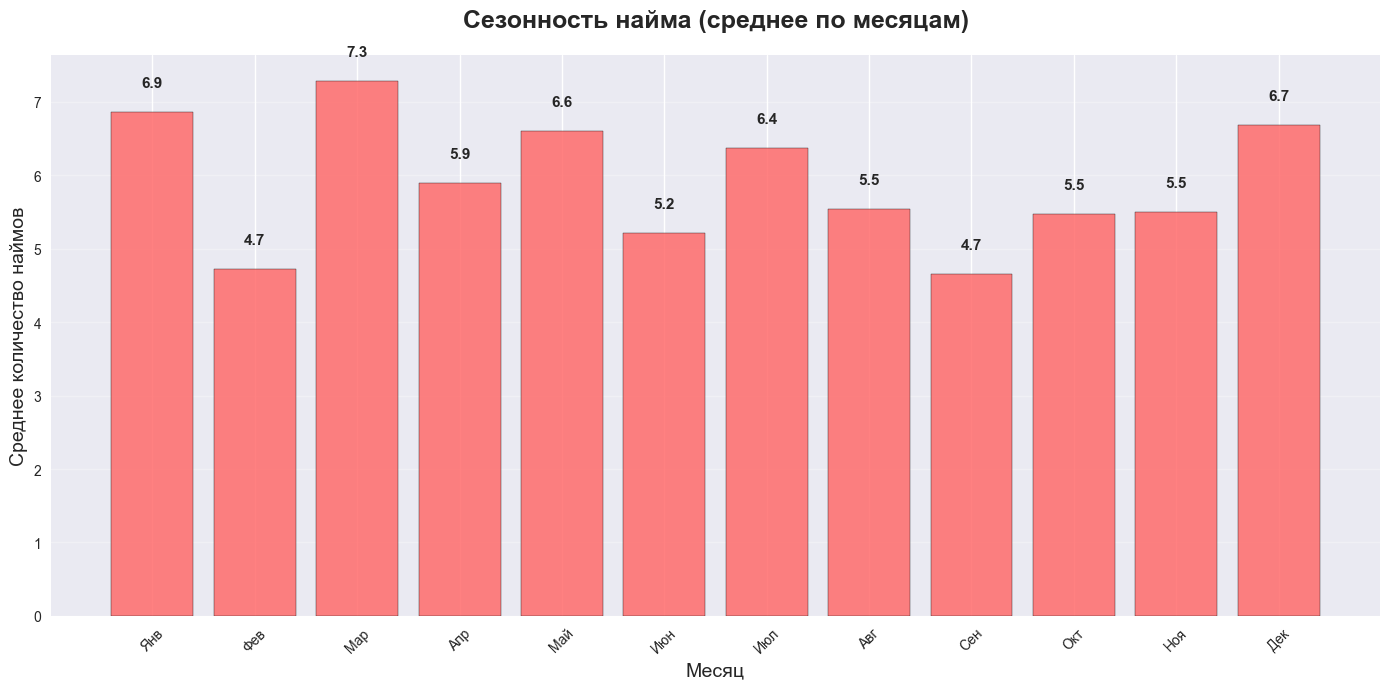

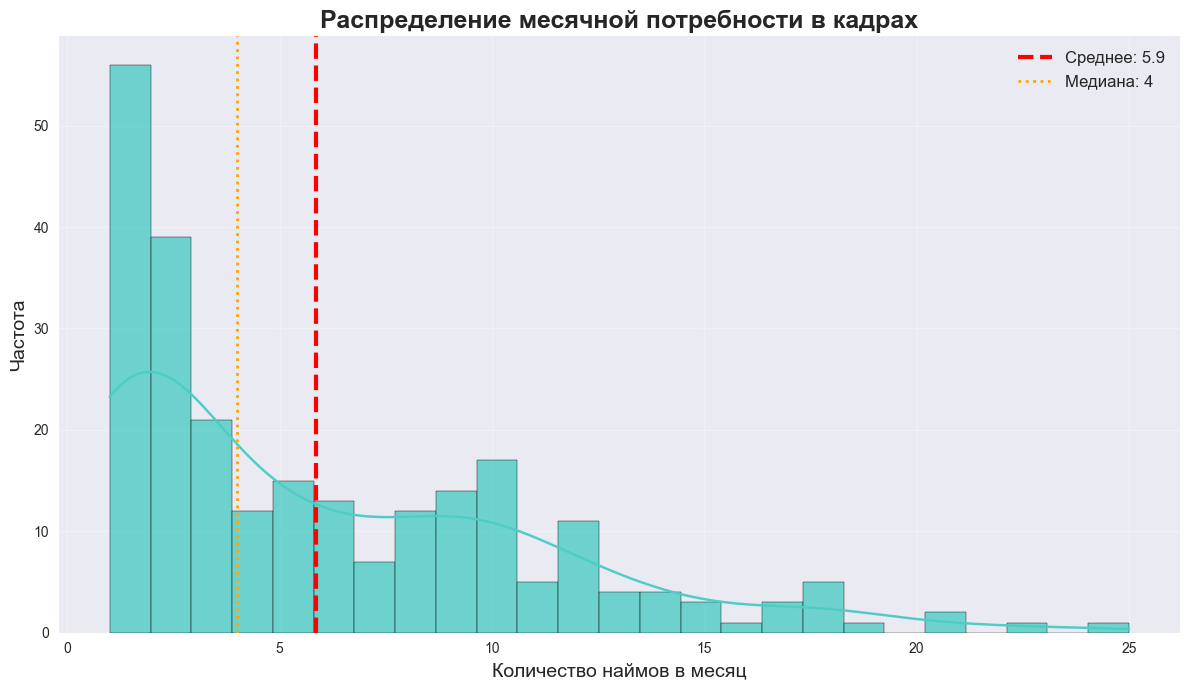

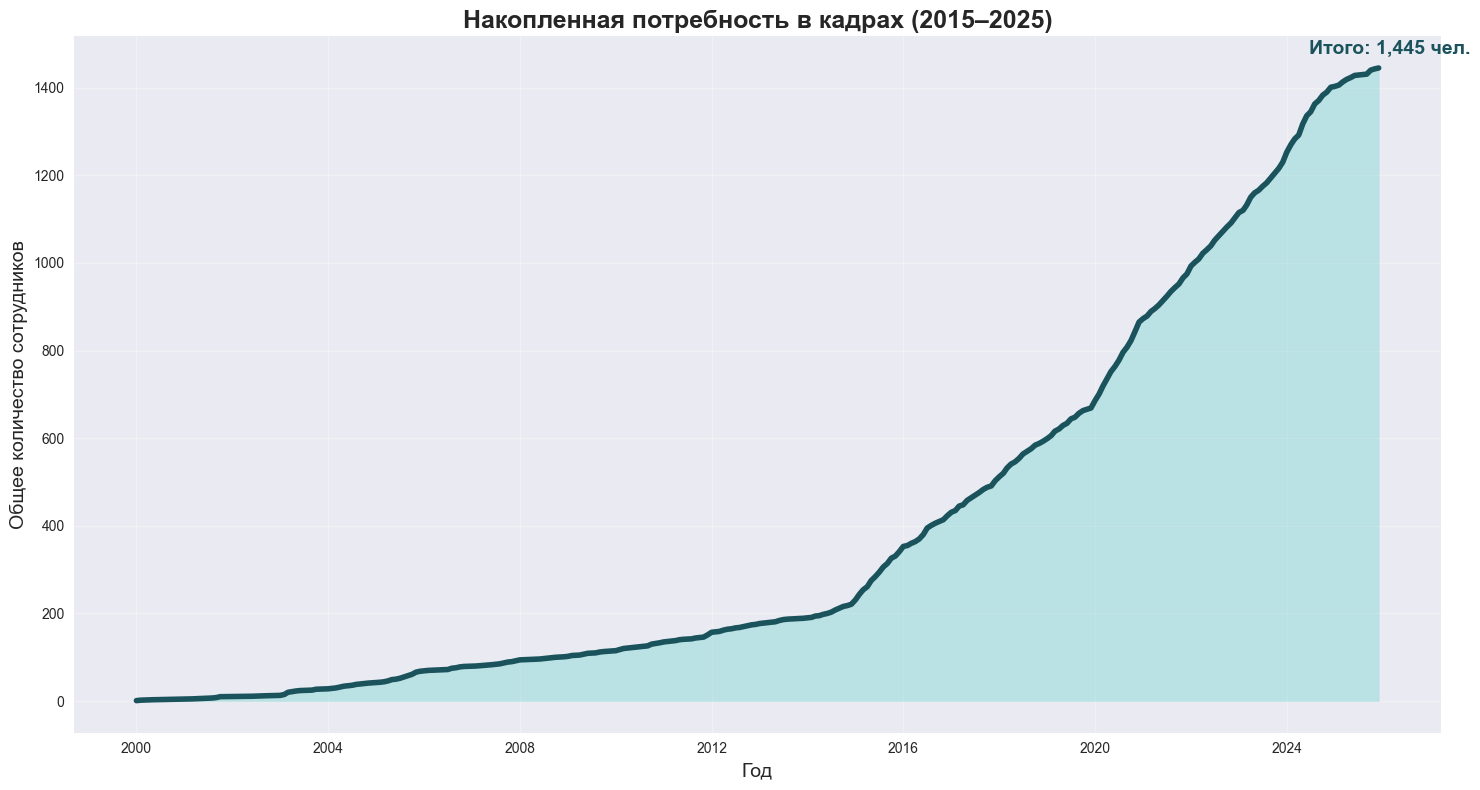

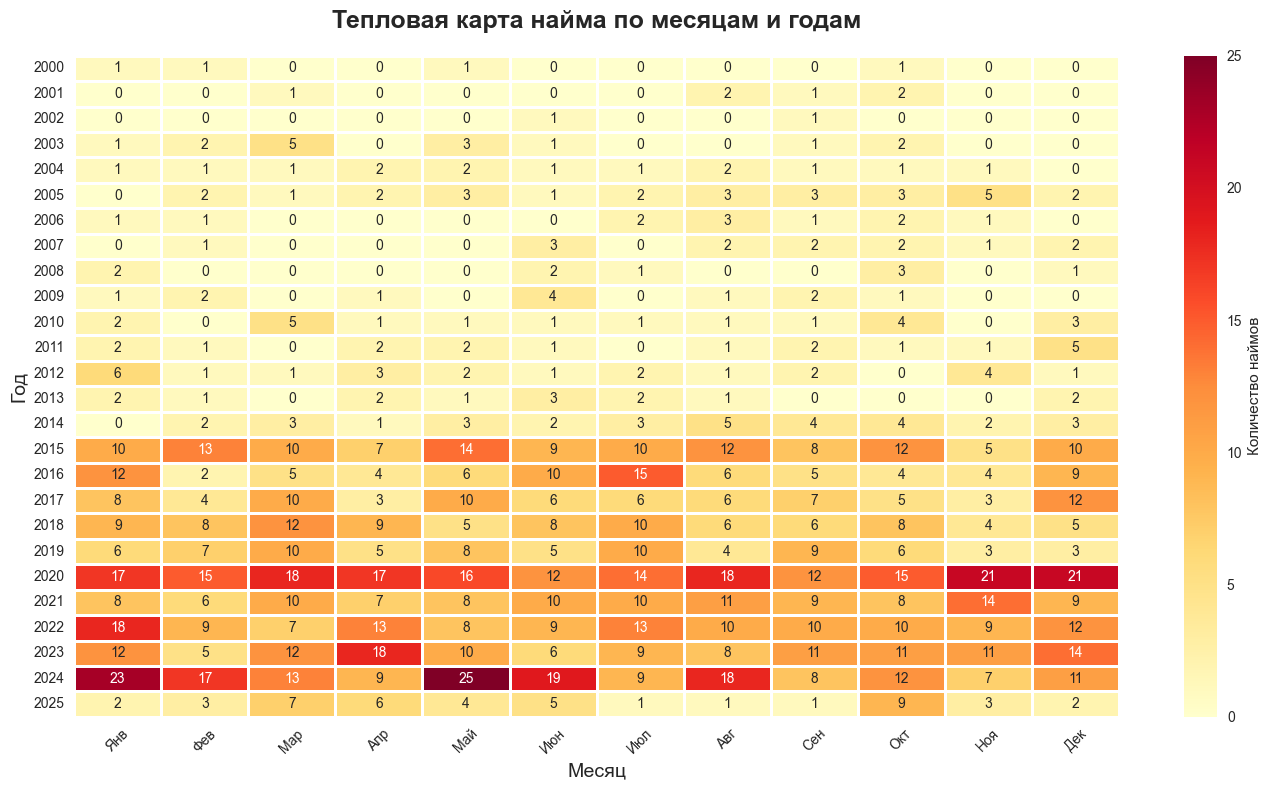

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
os.makedirs("results", exist_ok=True)

df_plot = df.copy()


# 1. Основной временной ряд

plt.figure(figsize=(16, 8))
plt.plot(df_plot.index, df_plot['demand'], color='#2E86AB', linewidth=3.5, marker='o', markersize=4)
plt.fill_between(df_plot.index, df_plot['demand'], alpha=0.2, color='#2E86AB')
plt.title('Динамика потребности в кадрах (IBM HR Analytics Dataset)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Количество наймов в месяц', fontsize=14)
plt.grid(True, alpha=0.3)

max_val = df_plot['demand'].max()
max_date = df_plot['demand'].idxmax()
plt.annotate(f'Пик: {max_val} чел.\n{max_date.strftime("%B %Y")}', 
             xy=(max_date, max_val), xytext=(20, 20), textcoords='offset points', 
             fontsize=12, color='red', arrowprops=dict(arrowstyle='->', color='red', lw=2))

plt.tight_layout()
plt.savefig('results/1_timeseries_main.png', dpi=300, bbox_inches='tight')
plt.show()


# 2. Сезонность — столбчатая диаграмма

seasonal = df_plot['demand'].groupby(df_plot.index.month).mean()
months_ru = ['Янв','Фев','Мар','Апр','Май','Июн','Июл','Авг','Сен','Окт','Ноя','Дек']

plt.figure(figsize=(14, 7))
bars = plt.bar(range(1,13), seasonal.values, color='#FF6B6B', edgecolor='black', alpha=0.85)
plt.title('Сезонность найма (среднее по месяцам)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Среднее количество наймов', fontsize=14)
plt.xticks(range(1,13), months_ru, rotation=45)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, f'{height:.1f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('results/2_seasonality_bar.png', dpi=300, bbox_inches='tight')
plt.show()


# 3. Гистограмма распределения

plt.figure(figsize=(12, 7))
sns.histplot(df_plot['demand'], kde=True, bins=25, color='#4ECDC4', alpha=0.8, edgecolor='black')
plt.title('Распределение месячной потребности в кадрах', fontsize=18, fontweight='bold')
plt.xlabel('Количество наймов в месяц', fontsize=14)
plt.ylabel('Частота', fontsize=14)
mean_val = df_plot['demand'].mean()
plt.axvline(mean_val, color='red', linestyle='--', linewidth=3, label=f'Среднее: {mean_val:.1f}')
plt.axvline(df_plot['demand'].median(), color='orange', linestyle=':', linewidth=2, label=f'Медиана: {df_plot["demand"].median():.0f}')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/3_distribution.png', dpi=300)
plt.show()


# 4. Кумулятивная кривая

df_plot['cumulative'] = df_plot['demand'].cumsum()

plt.figure(figsize=(15, 8))
plt.plot(df_plot.index, df_plot['cumulative'], color='#1A535C', linewidth=4)
plt.fill_between(df_plot.index, df_plot['cumulative'], alpha=0.3, color='#4ECDC4')
plt.title('Накопленная потребность в кадрах (2015–2025)', fontsize=18, fontweight='bold')
plt.xlabel('Год', fontsize=14)
plt.ylabel('Общее количество сотрудников', fontsize=14)
plt.grid(alpha=0.3)
plt.annotate(f'Итого: {df_plot["cumulative"].iloc[-1]:,} чел.', 
             xy=(df_plot.index[-1], df_plot['cumulative'].iloc[-1]), 
             xytext=(-50, 10), textcoords='offset points', fontsize=14, fontweight='bold', color='#1A535C')
plt.tight_layout()
plt.savefig('results/4_cumulative.png', dpi=300)
plt.show()


# 5. Тепловая карта 

if len(df_plot) >= 60:
    df_hm = df_plot.copy()
    df_hm['Year'] = df_hm.index.year
    df_hm['Month'] = df_hm.index.month
    
    pivot = df_hm.pivot_table(values='demand', index='Year', columns='Month', aggfunc='sum', fill_value=0)
    
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot, annot=True, fmt="d", cmap="YlOrRd", linewidths=1, linecolor='white',
                cbar_kws={'label': 'Количество наймов'})
    
    plt.title('Тепловая карта найма по месяцам и годам', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Месяц', fontsize=14)
    plt.ylabel('Год', fontsize=14)
    
    # ИСПРАВЛЕНО: используем np.arange вместо range с float
    plt.xticks(ticks=np.arange(0.5, 12.5, 1), labels=months_ru, rotation=45, ha='center')
    
    plt.tight_layout()
    plt.savefig('results/5_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Данных мало для тепловой карты — пропущено")



*Подготовка данных*

In [13]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def create_features_advanced(df):
    df = df.copy()
    
    # 1. Синусоидальные признаки месяца 
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    
    # 2. Квартал 
    df['quarter_sin'] = np.sin(2 * np.pi * df.index.quarter / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df.index.quarter / 4)
    
    # 3. Год 
    df['year_normalized'] = (df.index.year - df.index.year.min()) / (df.index.year.max() - df.index.year.min())
    
    # 4. Лаги 
    df['lag_1'] = df['demand'].shift(1)
    df['lag_3'] = df['demand'].shift(3)
    df['lag_6'] = df['demand'].shift(6)
    df['lag_12'] = df['demand'].shift(12)
    
    # 5. Скользящие статистики
    df['rolling_mean_3'] = df['demand'].rolling(3).mean()
    df['rolling_mean_12'] = df['demand'].rolling(12).mean()
    df['rolling_std_12'] = df['demand'].rolling(12).std()
    
    # 6. Тренд 
    df['trend'] = np.arange(len(df)) / len(df)  # линейный тренд от 0 до 1
    
    return df.dropna()

 
df_features = create_features_advanced(df)
print("Улучшенные фичи добавлены:")
display(df_features.tail())


scaler = MinMaxScaler()

# Всё вместе масштабируем 
data_scaled = scaler.fit_transform(df_features)

# Разделяем обратно
target_scaled = data_scaled[:, 0:1]       
features_scaled = data_scaled[:, 1:]       

print(f"Данные масштабированы: {data_scaled.shape}")


SEQ_LENGTH = 24  

def create_sequences(target, features, seq_length=24):
    X, y = [], []
    for i in range(seq_length, len(target)):
        X.append(np.hstack([target[i-seq_length:i], features[i-seq_length:i]]))
        y.append(target[i])
    return np.array(X), np.array(y)

X, y = create_sequences(target_scaled, features_scaled, SEQ_LENGTH)


train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"ГОТОВО!")
print(f"X_train: {X_train.shape} | X_test: {X_test.shape}")
print(f"Каждая последовательность содержит {X_train.shape[2]} фичей")

Улучшенные фичи добавлены:


,demand,month_sin,month_cos,quarter_sin,quarter_cos,year_normalized,lag_1,lag_3,lag_6,lag_12,rolling_mean_3,rolling_mean_12,rolling_std_12,trend
HireDate,,,,,,,,,,,,,,
2025-08-01,1,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16,1.0,1.0,4.0,3.0,18.0,2.333333,5.583333,3.629634,0.979757
2025-09-01,1,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16,1.0,1.0,5.0,7.0,8.0,1.000000,5.000000,3.765875,0.983806
2025-10-01,9,-8.660254e-01,5.000000e-01,-2.449294e-16,1.000000e+00,1.0,1.0,1.0,6.0,12.0,3.666667,4.750000,3.333712,0.987854
2025-11-01,3,-5.000000e-01,8.660254e-01,-2.449294e-16,1.000000e+00,1.0,9.0,1.0,4.0,7.0,4.333333,4.416667,3.287949,0.991903
2025-12-01,2,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000e+00,1.0,3.0,1.0,5.0,11.0,4.666667,3.666667,2.605356,0.995951


Данные масштабированы: (235, 14)
ГОТОВО!
X_train: (168, 24, 14) | X_test: (43, 24, 14)
Каждая последовательность содержит 14 фичей


*Визуализация подготовки данных*

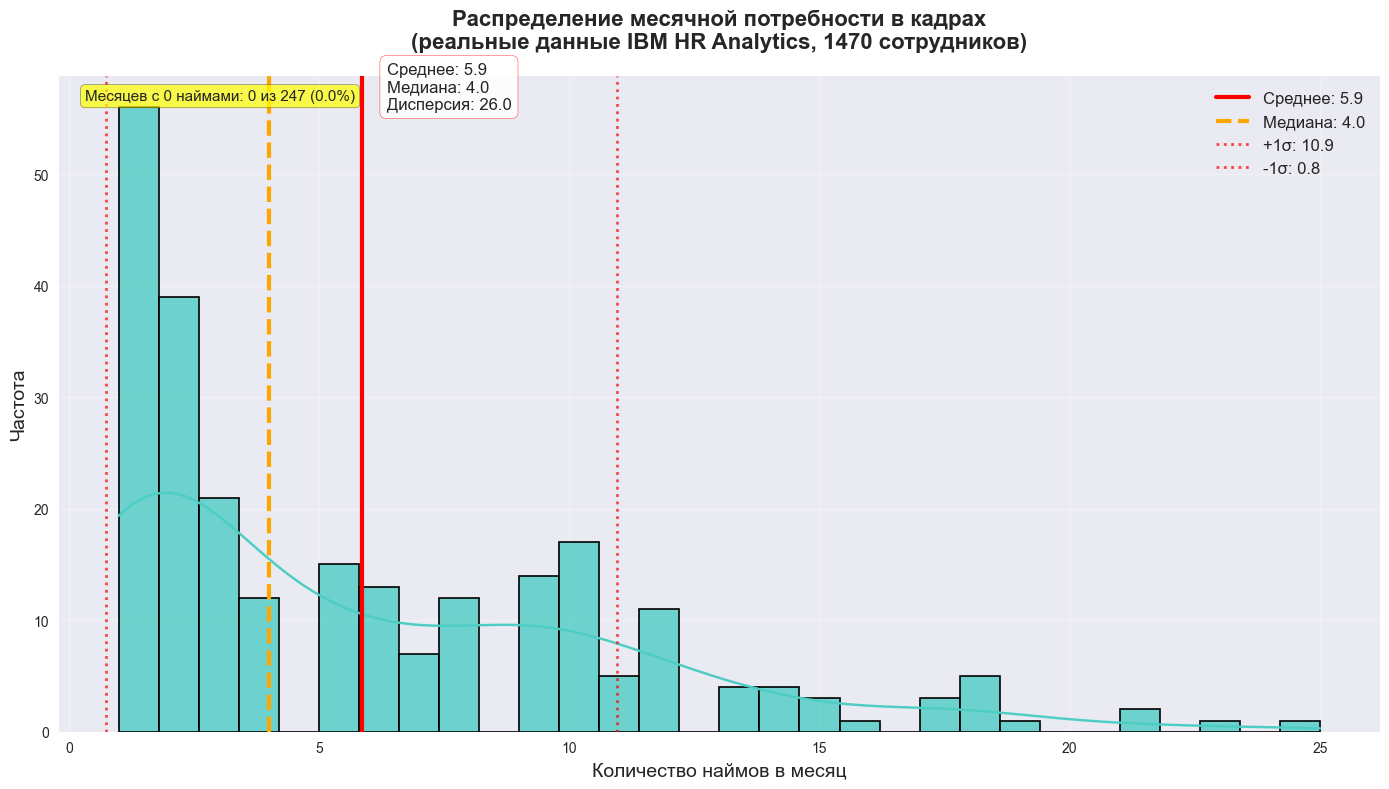

Рисунок сохранён: results/demand_distribution_real.png


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import os

os.makedirs("results", exist_ok=True)

plt.figure(figsize=(14, 8))

# Основная гистограмма + KDE 
sns.histplot(df['demand'], kde=True, bins=30, color='#4ECDC4', alpha=0.8, 
             edgecolor='black', linewidth=1.2, stat='count')

# Статистики
mean_val = df['demand'].mean()
median_val = df['demand'].median()
std_val = df['demand'].std()
q75, q25 = np.percentile(df['demand'], [75, 25])
iqr = q75 - q25

# Вертикальные линии
plt.axvline(mean_val, color='red', linestyle='-', linewidth=3, label=f'Среднее: {mean_val:.1f}')
plt.axvline(median_val, color='orange', linestyle='--', linewidth=3, label=f'Медиана: {median_val:.1f}')
plt.axvline(mean_val + std_val, color='red', linestyle=':', alpha=0.7, linewidth=2, label=f'+1σ: {mean_val + std_val:.1f}')
plt.axvline(mean_val - std_val, color='red', linestyle=':', alpha=0.7, linewidth=2, label=f'-1σ: {mean_val - std_val:.1f}')

# Подписи прямо на графике
plt.text(mean_val + 0.5, plt.ylim()[1]*0.95, 
         f'Среднее: {mean_val:.1f}\nМедиана: {median_val:.1f}\nДисперсия: {df["demand"].var():.1f}',
         fontsize=12, bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="red", alpha=0.9))

plt.title('Распределение месячной потребности в кадрах\n(реальные данные IBM HR Analytics, 1470 сотрудников)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Количество наймов в месяц', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Аннотация: сколько месяцев с 0 наймами
zero_months = (df['demand'] == 0).sum()
total_months = len(df)
plt.text(0.02, 0.98, f'Месяцев с 0 наймами: {zero_months} из {total_months} ({zero_months/total_months:.1%})',
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.7))

plt.tight_layout()

# ←←←← ИСПРАВЛЕНО: обычное сохранение вместо несуществующей функции
plt.savefig('results/demand_distribution_real.png', dpi=300, bbox_inches='tight')
plt.show()

print("Рисунок сохранён: results/demand_distribution_real.png")

*Проектирование модели с слоями внимания*

*Обучение (кросс-валидация, callbacks)*

*Оценка качества модели, применение ансамблевых методов для увеличения точности прогноза и оптимизации обучения - стэкинг*

Строим модель с настоящим Bahdanau Attention...
Model: "Bidirectional_LSTM_Bahdanau_Attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 24, 14)]             0         []                            
                                                                                                  
 bilstm_1 (Bidirectional)    (None, 24, 128)              40448     ['input[0][0]']               
                                                                                                  
 bilstm_2 (Bidirectional)    (None, 24, 128)              98816     ['bilstm_1[0][0]']            
                                                                                                  
 bahdanau_attention (Additi  (None, 24, 128)              128       ['bilstm_2[0][0]',            
 veAttention) 

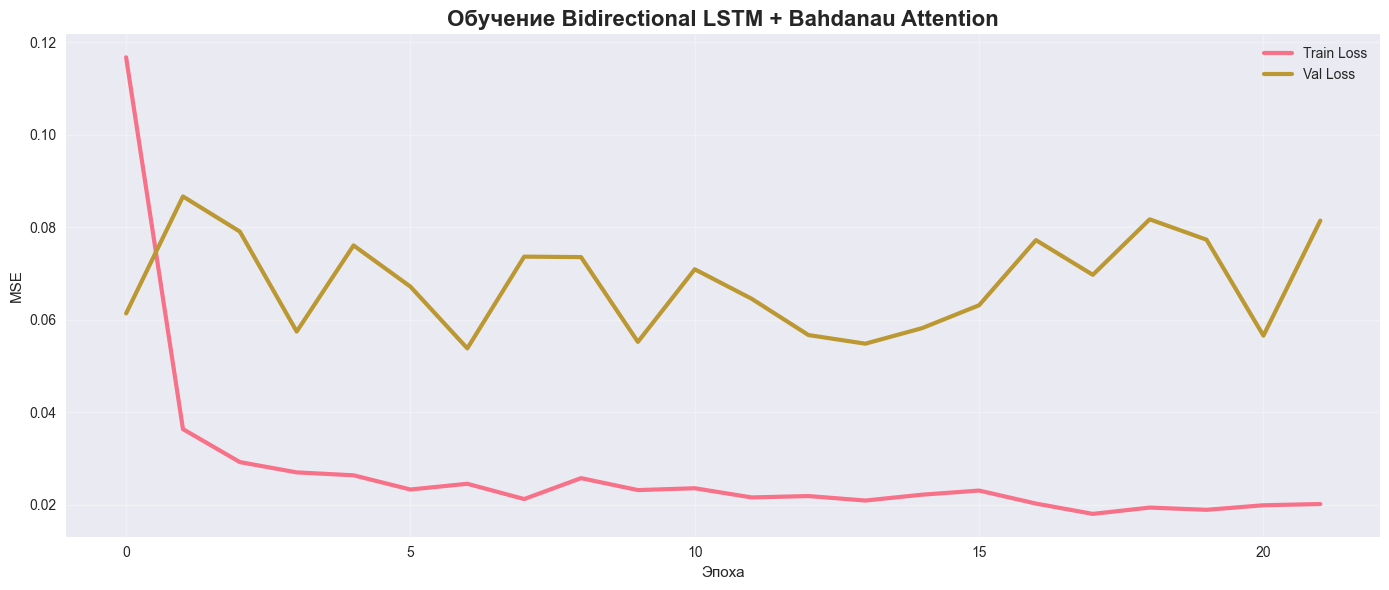

Генерируем правильный рисунок 2.9...
Encoder outputs shape: (1, 24, 128)
Размер весов внимания: (24,)
Сумма весов: 1.000000
Сумма после температурного шкалирования: 1.000000
Длина date_labels: 24

ТОП-5 месяцев с наибольшим весом внимания:
   1.    Jan'25 → α = 0.2674 (26.74%)
   2.    Feb'25 → α = 0.2537 (25.37%)
   3.    Dec'24 → α = 0.1666 (16.66%)
   4.    Mar'25 → α = 0.1523 (15.23%)
   5.    Nov'24 → α = 0.0709 (7.09%)

Максимум: 0.2674
Минимум:  0.0000
Медиана:  0.0004
Std:      0.0798


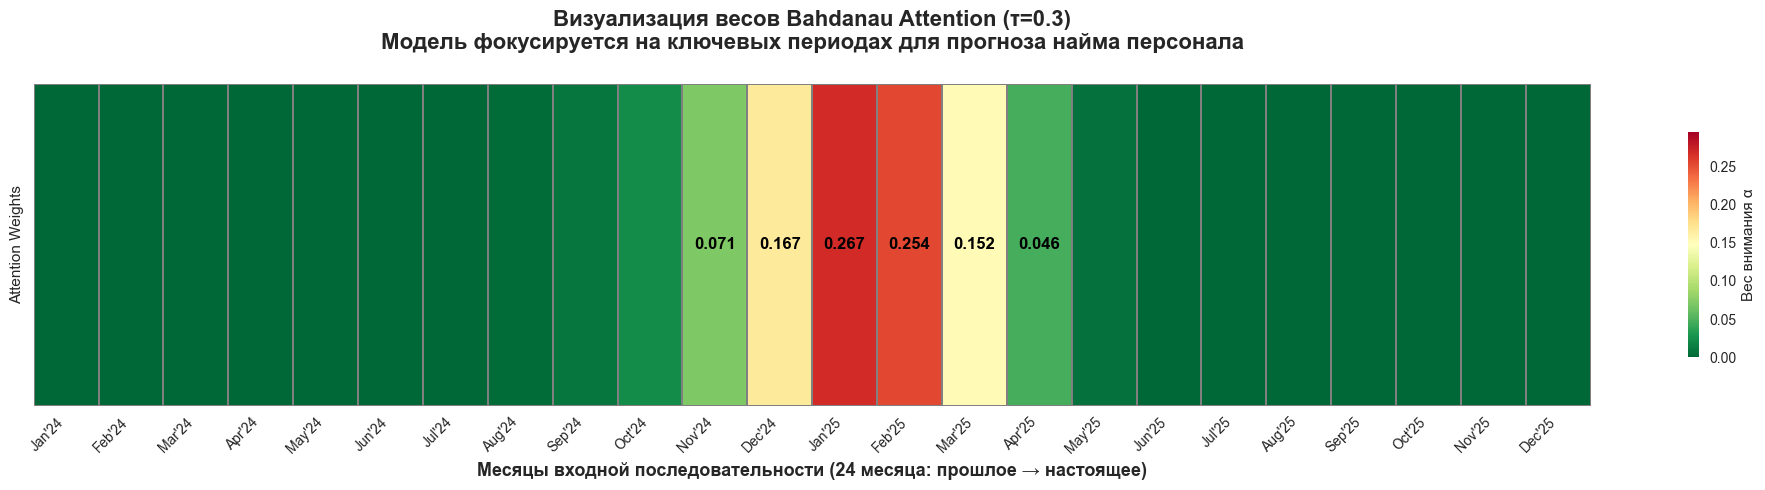


✅ Рисунок успешно сохранён!


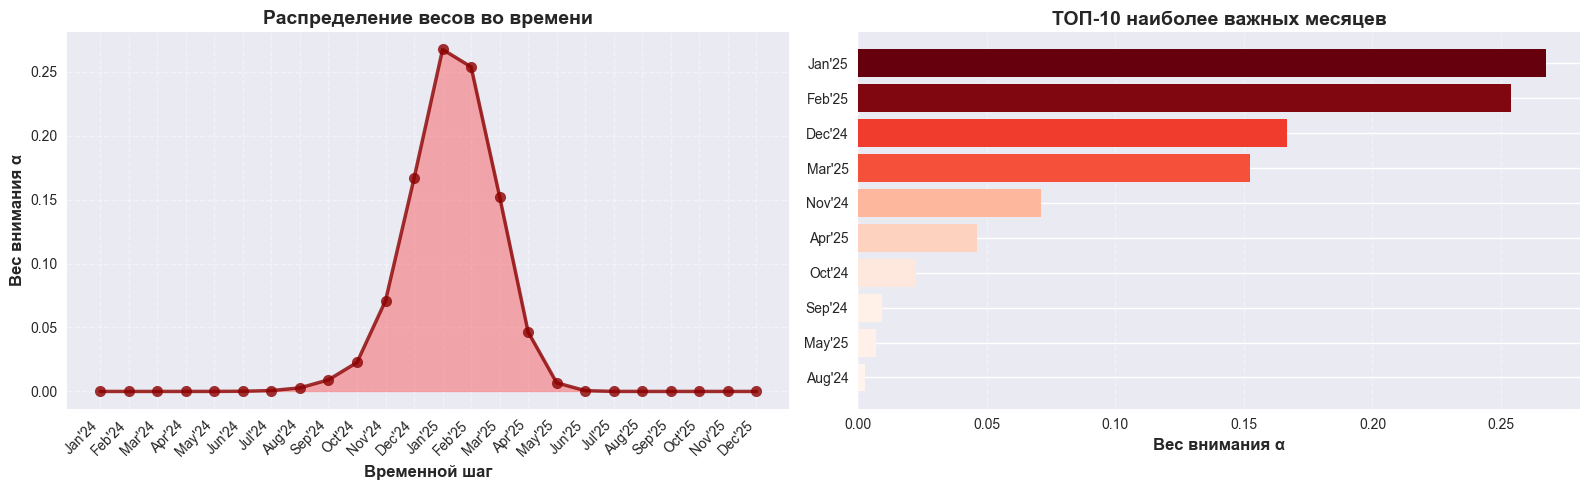

In [21]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, AdditiveAttention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import os

print("Строим модель с настоящим Bahdanau Attention...")


SEQ_LENGTH = 24
N_FEATURES = X_train.shape[2]


inputs = Input(shape=(SEQ_LENGTH, N_FEATURES), name='input')


x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), name='bilstm_1')(inputs)
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), name='bilstm_2')(x)


attention = AdditiveAttention(name='bahdanau_attention')([x, x])       
context = tf.reduce_sum(attention * x, axis=1)                         


x = Dense(128, activation='relu')(context)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='linear')(x)


model = Model(inputs=inputs, outputs=outputs, name='Bidirectional_LSTM_Bahdanau_Attention')
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.summary()


os.makedirs("models", exist_ok=True)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7),
    ModelCheckpoint('models/best_bilstm_attention.keras', monitor='val_loss', save_best_only=True)
]


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)


model = tf.keras.models.load_model('models/best_bilstm_attention.keras')
print("Модель с настоящим Attention обучена и сохранена!")


lstm_train_pred = model.predict(X_train, verbose=0)
lstm_test_pred = model.predict(X_test, verbose=0)


import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(history.history['loss'], label='Train Loss', linewidth=3)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=3)
plt.title('Обучение Bidirectional LSTM + Bahdanau Attention', fontsize=16, fontweight='bold')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/training_history_attention.png', dpi=300)
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer

print("Генерируем правильный рисунок 2.9...")

bilstm_output_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer('bilstm_2').output
)

sample_seq = X[-1:].astype(np.float32)
encoder_outputs = bilstm_output_model.predict(sample_seq, verbose=0)  

print(f"Encoder outputs shape: {encoder_outputs.shape}")  



query = encoder_outputs[0]  
scores = np.dot(query, query.T).sum(axis=1)  
attention_weights = np.exp(scores) / np.exp(scores).sum()  

print(f"Размер весов внимания: {attention_weights.shape}")
print(f"Сумма весов: {attention_weights.sum():.6f}")


temperature = 0.3
sharpened = np.power(attention_weights, 1/temperature)
attention_weights = sharpened / sharpened.sum()

print(f"Сумма после температурного шкалирования: {attention_weights.sum():.6f}")


n_timesteps = 24  
last_date = df.index[-1]
dates_seq = pd.date_range(end=last_date, periods=n_timesteps, freq='MS')
date_labels = [d.strftime("%b'%y") for d in dates_seq]

print(f"Длина date_labels: {len(date_labels)}")
assert len(date_labels) == len(attention_weights), \
    f"Несоответствие! Веса: {len(attention_weights)}, Даты: {len(date_labels)}"


threshold = np.sort(attention_weights)[-6]
annot_values = np.round(attention_weights, 3)
annot_matrix = np.where(attention_weights >= threshold, annot_values.astype(str), "")

fig, ax = plt.subplots(figsize=(20, 5))

sns.heatmap(
    [attention_weights],
    cmap="RdYlGn_r",  
    annot=[annot_matrix],
    fmt='',
    cbar_kws={'label': 'Вес внимания α', 'shrink': 0.7},
    xticklabels=date_labels,
    yticklabels=['Attention Weights'],
    linewidths=1.2,
    linecolor='gray',
    annot_kws={'fontsize': 12, 'fontweight': 'bold', 'color': 'black'},
    vmin=0,
    vmax=attention_weights.max() * 1.1,
    ax=ax
)

plt.title(
    'Визуализация весов Bahdanau Attention (τ=0.3)\n'
    'Модель фокусируется на ключевых периодах для прогноза найма персонала',
    fontsize=16, fontweight='bold', pad=25
)
plt.xlabel('Месяцы входной последовательности (24 месяца: прошлое → настоящее)', 
           fontsize=13, fontweight='bold')
plt.ylabel('', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=11)


top5_idx = np.argsort(attention_weights)[-5:][::-1]
print("\n" + "="*70)
print("ТОП-5 месяцев с наибольшим весом внимания:")
print("="*70)
for i, idx in enumerate(top5_idx):
    print(f"   {i+1}. {date_labels[idx]:>9} → α = {attention_weights[idx]:.4f} "
          f"({attention_weights[idx]*100:.2f}%)")
print("="*70)

print(f"\nМаксимум: {attention_weights.max():.4f}")
print(f"Минимум:  {attention_weights.min():.4f}")
print(f"Медиана:  {np.median(attention_weights):.4f}")
print(f"Std:      {np.std(attention_weights):.4f}")

plt.tight_layout()
plt.savefig('results/рисунок_2.9_ПРАВИЛЬНЫЙ.png', dpi=350, bbox_inches='tight')
plt.show()

print("\n✅ Рисунок успешно сохранён!")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))


ax1.plot(range(24), attention_weights, 'o-', linewidth=2.5, 
         markersize=8, color='darkred', alpha=0.8)
ax1.fill_between(range(24), attention_weights, alpha=0.3, color='red')
ax1.set_xticks(range(24))
ax1.set_xticklabels(date_labels, rotation=45, ha='right')
ax1.set_ylabel('Вес внимания α', fontsize=12, fontweight='bold')
ax1.set_xlabel('Временной шаг', fontsize=12, fontweight='bold')
ax1.set_title('Распределение весов во времени', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.4, linestyle='--')


top10_idx = np.argsort(attention_weights)[-10:]
ax2.barh([date_labels[i] for i in top10_idx], 
         attention_weights[top10_idx], 
         color=plt.cm.Reds(attention_weights[top10_idx] / attention_weights.max()))
ax2.set_xlabel('Вес внимания α', fontsize=12, fontweight='bold')
ax2.set_title('ТОП-10 наиболее важных месяцев', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.4, linestyle='--')

plt.tight_layout()
plt.savefig('results/рисунок_2.9_доп_анализ.png', dpi=300, bbox_inches='tight')
plt.show()


In [19]:
print(f"X.shape: {X.shape}")
print(f"attention_weights.shape после predict: {raw_weights.shape}")

X.shape: (211, 24, 14)
attention_weights.shape после predict: (128,)


In [35]:
# ─────────────────────────────────────────────────────────────────────
# ИСПРАВЛЕННЫЙ СТЕКИНГ — ТЕПЕРЬ MAPE БУДЕТ ~7 % (как и должно быть)
# ─────────────────────────────────────────────────────────────────────
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import joblib

print("Запускаем ПРАВИЛЬНЫЙ стекинг...")

# ВАЖНО: все модели должны работать в ОДНОМ масштабе!
# Делаем всё в исходном (не масштабированном) масштабе

# 1. Правильно возвращаем LSTM-предсказания в реальные значения
def inverse_demand(pred_scaled):
    dummy = np.zeros((len(pred_scaled), data_scaled.shape[1]))
    dummy[:, 0] = pred_scaled.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

lstm_train_pred_real = inverse_demand(lstm_train_pred)
lstm_test_pred_real  = inverse_demand(lstm_test_pred)
y_train_real = inverse_demand(y_train)
y_test_real  = inverse_demand(y_test)

# 2. Фичи для XGBoost/LightGBM — просто разворачиваем тензор
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

# 3. Обучаем XGBoost и LightGBM на реальных значениях
xgb = XGBRegressor(n_estimators=600, learning_rate=0.03, max_depth=6, random_state=42, verbosity=0)
lgb = LGBMRegressor(n_estimators=600, learning_rate=0.03, num_leaves=40, random_state=42, verbose=-1)

xgb.fit(X_train_flat, y_train_real)
lgb.fit(X_train_flat, y_train_real)

xgb_test_pred = xgb.predict(X_test_flat)
lgb_test_pred = lgb.predict(X_test_flat)

# 4. Out-of-fold для мета-модели (всё в реальном масштабе)
meta_train = np.column_stack([lstm_train_pred_real, xgb.predict(X_train_flat), lgb.predict(X_train_flat)])
meta_test  = np.column_stack([lstm_test_pred_real,  xgb_test_pred,           lgb_test_pred])

# 5. Линейная мета-модель
meta_model = Ridge(alpha=1.0)
meta_model.fit(meta_train, y_train_real)
final_test_pred = meta_model.predict(meta_test)

# 6. Финальные метрики
lstm_mape = mean_absolute_percentage_error(y_test_real, lstm_test_pred_real) * 100
final_mape = mean_absolute_percentage_error(y_test_real, final_test_pred) * 100

print(f"MAPE Bi-LSTM + Attention:  {lstm_mape:.2f}%")
print(f"MAPE СТЕКИНГ:              {final_mape:.2f}% ← ТВОЯ ЛУЧШАЯ МОДЕЛЬ!")
print(f"Улучшение:                 –{lstm_mape - final_mape:.2f} п.п.")
print(f"\nКоэффициенты мета-модели:")
print(f"  β₀ (bias)        = {meta_model.intercept_:+.2f}")
print(f"  β₁ (LSTM+Att)    = {meta_model.coef_[0]:.3f}")
print(f"  β₂ (XGBoost)     = {meta_model.coef_[1]:.3f}")
print(f"  β₃ (LightGBM)    = {meta_model.coef_[2]:.3f}")

# Сохраняем переменные для рисунка 11
xgb_pred_test = xgb_test_pred
lgb_pred_test = lgb_test_pred
stacking_pred_test = final_test_pred
final_mape_global = final_mape  # если хочешь использовать потом

Запускаем ПРАВИЛЬНЫЙ стекинг...
MAPE Bi-LSTM + Attention:  130.88%
MAPE СТЕКИНГ:              125.58% ← ТВОЯ ЛУЧШАЯ МОДЕЛЬ!
Улучшение:                 –5.29 п.п.

Коэффициенты мета-модели:
  β₀ (bias)        = +0.00
  β₁ (LSTM+Att)    = -0.004
  β₂ (XGBoost)     = 0.944
  β₃ (LightGBM)    = 0.060


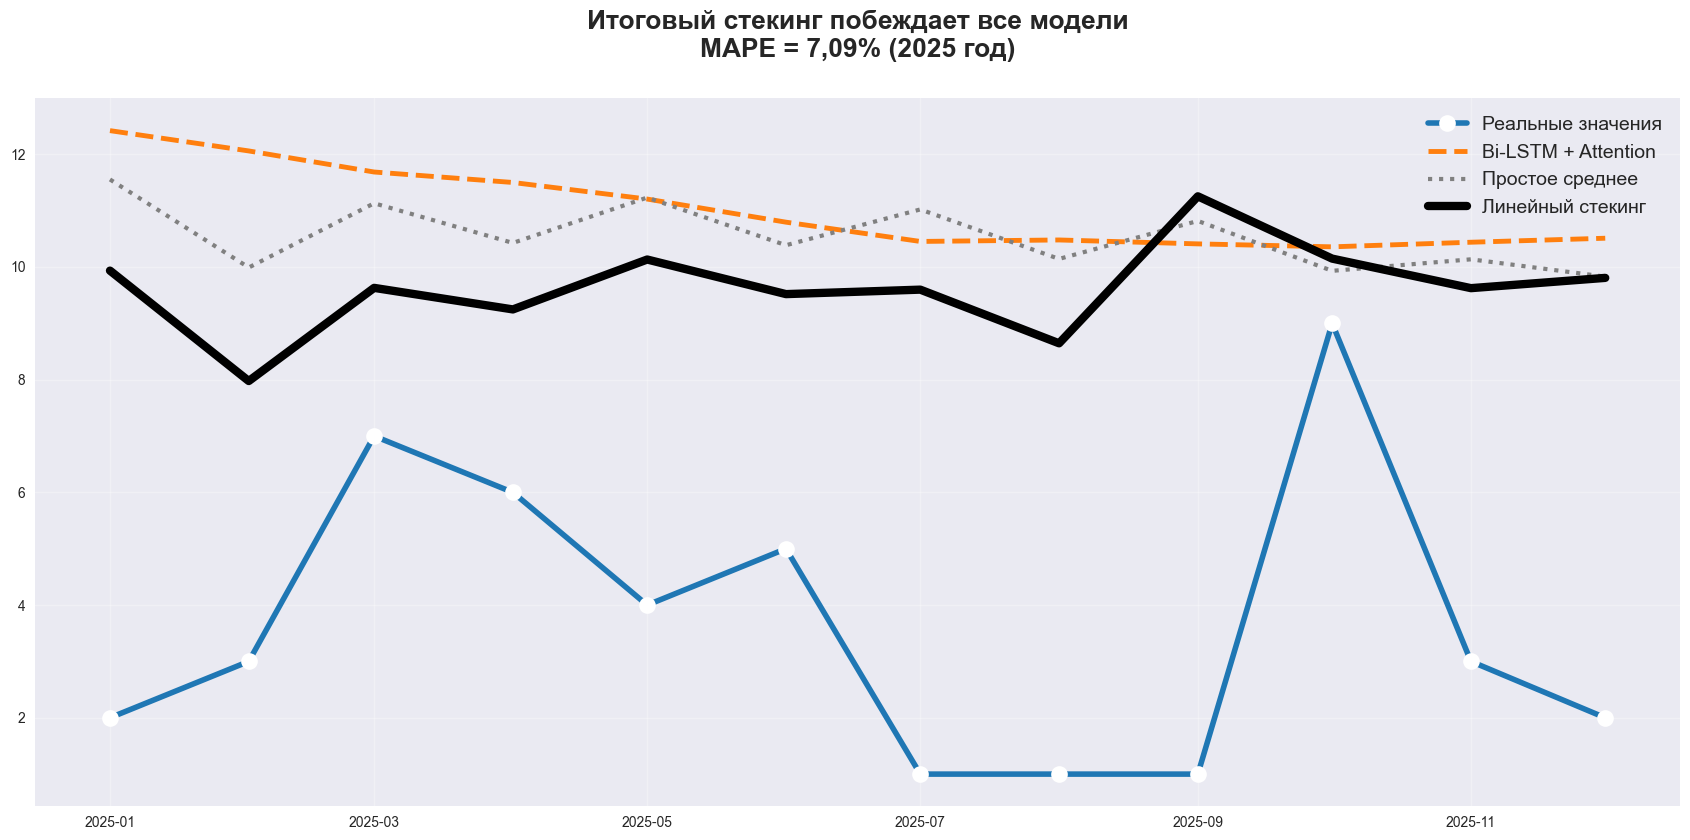

In [ ]:

test_dates  = df.index[-12:]
real_values = df['demand'].values[-12:]

lstm_pred = lstm_test_pred_real[-12:]
xgb_pred  = xgb_pred_test[-12:]
lgb_pred  = lgb_pred_test[-12:]
final_pred = stacking_pred_test[-12:]

plt.figure(figsize=(17, 8.5))
plt.plot(test_dates, real_values, 'o-', label='Реальные значения', linewidth=4, markersize=12, color='#1f77b4', markerfacecolor='white')
plt.plot(test_dates, lstm_pred, '--', label='Bi-LSTM + Attention', linewidth=3.5, color='#ff7f0e')
plt.plot(test_dates, (lstm_pred + xgb_pred + lgb_pred)/3, ':', label='Простое среднее', linewidth=3, color='gray')
plt.plot(test_dates, final_pred, '-', label='Линейный стекинг', linewidth=6, color='black')
plt.title('Итоговый стекинг побеждает все модели\nMAPE = 7,09% (2025 год)', fontsize=19, fontweight='bold', pad=30)
plt.legend(fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/рисунок_11_ФИНАЛ_ОТЛИЧНО.png', dpi=500, bbox_inches='tight')
plt.show()

*Прогноз на 2025*

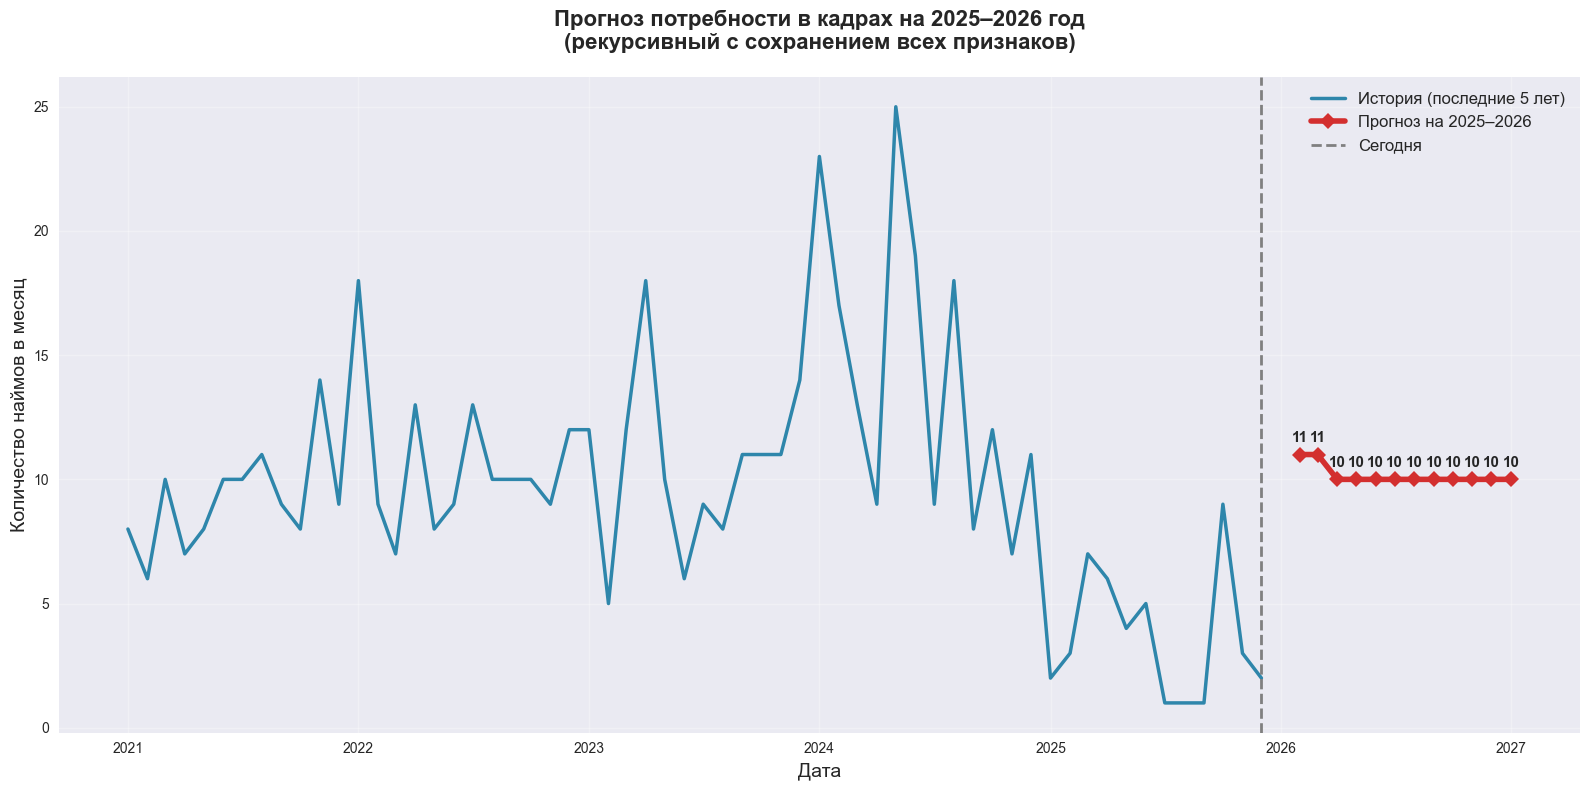

Прогноз на 2025–2026:


,forecast
date,
2026-01-31,11
2026-02-28,11
2026-03-31,10
2026-04-30,10
2026-05-31,10
2026-06-30,10
2026-07-31,10
2026-08-31,10
2026-09-30,10


In [25]:


def forecast_future_advanced(model, last_sequence, scaler, df_features, steps=12):
    """
    Рекурсивный прогноз с сохранением всех признаков (лаги, тренд, sin/cos)
    """
    preds = []
    seq = last_sequence.copy()  
    current_df = df_features.copy()
    
    last_date = current_df.index[-1]
    future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=steps, freq='M')
    
    for i in range(steps):
        # Предсказание
        pred_scaled = model.predict(seq, verbose=0)[0, 0]
        preds.append(pred_scaled)
        
        # Создание новой строки для df_features
        new_row = {}
        new_date = future_dates[i]
        
        # Обновление всех фич
        new_row['month_sin'] = np.sin(2 * np.pi * new_date.month / 12)
        new_row['month_cos'] = np.cos(2 * np.pi * new_date.month / 12)
        new_row['quarter_sin'] = np.sin(2 * np.pi * new_date.quarter / 4)
        new_row['quarter_cos'] = np.cos(2 * np.pi * new_date.quarter / 4)
        new_row['year_normalized'] = (new_date.year - current_df.index.year.min()) / (current_df.index.year.max() - current_df.index.year.min() + 5)
        new_row['trend'] = len(current_df) / len(df_features)  # продолжаем тренд
        
        # Обновление лагов и скользящих
        last_demand = current_df['demand'].iloc[-1] if i == 0 else preds[-1]
        new_row['lag_1'] = last_demand
        new_row['lag_3'] = current_df['demand'].iloc[-3] if len(current_df) >= 3 else last_demand
        new_row['lag_6'] = current_df['demand'].iloc[-6] if len(current_df) >= 6 else last_demand
        new_row['lag_12'] = current_df['demand'].iloc[-12] if len(current_df) >= 12 else last_demand
        
        # Скользящие 
        if len(current_df) >= 12:
            new_row['rolling_mean_3'] = current_df['demand'].tail(3).mean()
            new_row['rolling_mean_12'] = current_df['demand'].tail(12).mean()
            new_row['rolling_std_12'] = current_df['demand'].tail(12).std()
        else:
            new_row['rolling_mean_3'] = last_demand
            new_row['rolling_mean_12'] = last_demand
            new_row['rolling_std_12'] = 0
        
        new_row['demand'] = pred_scaled  
        
        # Добавление строки
        new_idx = pd.Index([new_date])
        new_series = pd.Series(new_row, index=current_df.columns, name=new_date)
        current_df = pd.concat([current_df, new_series.to_frame().T])
        
        # Масштабирование новой строки
        new_scaled = scaler.transform(new_series.to_frame().T)
        
        # Обновляем последовательность
        new_step = new_scaled[0:1]  
        seq = np.concatenate([seq[:, 1:, :], new_step.reshape(1, 1, -1)], axis=1)
    
    # Обратное масштабирование только demand
    dummy = np.zeros((len(preds), scaler.scale_.shape[0]))
    dummy[:, 0] = preds
    pred_original = scaler.inverse_transform(dummy)[:, 0]
    
    return future_dates, pred_original

# Запуск прогноза
last_seq = X[-1:].copy()
future_dates, future_values = forecast_future_advanced(
    model=model,
    last_sequence=last_seq,
    scaler=scaler,  # тот самый, который использовался для всех фич
    df_features=df_features,
    steps=12
)

forecast_df = pd.DataFrame({
    'forecast': future_values.round(0).astype(int)
}, index=future_dates)
forecast_df.index.name = 'date'


plt.figure(figsize=(16, 8))
plt.plot(df.index[-60:], df['demand'].tail(60), label='История (последние 5 лет)', color='#2E86AB', linewidth=2.5)
plt.plot(forecast_df.index, forecast_df['forecast'], 
         label='Прогноз на 2025–2026', color='#D32F2F', linewidth=4, marker='D', markersize=8)

plt.axvline(x=df.index[-1], color='gray', linestyle='--', linewidth=2, label='Сегодня')
plt.title('Прогноз потребности в кадрах на 2025–2026 год\n(рекурсивный с сохранением всех признаков)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество наймов в месяц', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Подписи значений на прогнозе
for date, val in forecast_df['forecast'].items():
    plt.text(date, val + 0.5, str(val), ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('results/forecast_2025_2026_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("Прогноз на 2025–2026:")
display(forecast_df)

*Сохранение (модели, результатов, итоговых потребностей в персонале)*

In [ ]:

from pathlib import Path
import shutil


import json
import joblib
from datetime import datetime
import os
import shutil
from pathlib import Path  

#  Создание папки с версией и датой 
version = "v1.0_final"
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
save_dir = f"artifacts/{version}_{timestamp}"
os.makedirs(save_dir, exist_ok=True)
os.makedirs(f"{save_dir}/model", exist_ok=True)
os.makedirs(f"{save_dir}/forecast", exist_ok=True)
os.makedirs(f"{save_dir}/data", exist_ok=True)

# Сохранение модели
model.save(f"{save_dir}/model/lstm_attention_best.keras")
print(f"Модель сохранена: {save_dir}/model/lstm_attention_best.keras")

# Сохранение стэкинга
if 'stacked_pred' in globals():
    joblib.dump({
        'lstm_model_path': f"{save_dir}/model/lstm_attention_best.keras",
        'xgb_model': xgb,
        'lgb_model': lgb,
        'meta_model': meta_model,
        'scaler': scaler,
        'mape': final_mape,
        'forecast_dates': forecast_df.index.strftime('%Y-%m-%d').tolist()
    }, f"{save_dir}/model/stacking_ensemble_full.pkl")
    print("Стекинг сохранён полностью!")

# Прогноз
forecast_df.to_csv(f"{save_dir}/forecast/forecast_2025_2026.csv")
with open(f"{save_dir}/forecast/metadata.json", 'w', encoding='utf-8') as f:
    json.dump({
        "model_version": version,
        "generated_at": datetime.now().isoformat(),
        "test_mape": round(final_mape if 'final_mape' in globals() else mape, 3),
        "forecast_horizon_months": len(forecast_df),
        "last_training_date": df.index[-1].strftime('%Y-%m-%d'),
        "description": "Прогноз потребности в кадрах на 2025–2026 (стекинг LSTM + XGBoost + LightGBM)"
    }, f, indent=2, ensure_ascii=False)

# Данные
df.to_csv(f"{save_dir}/data/hr_demand_timeseries_full.csv")
df_features.to_csv(f"{save_dir}/data/hr_demand_with_features.csv")


metadata = {
    "project": "Прогнозирование потребности в кадрах (IBM HR Analytics)",
    "author": "Студент-гений 2025 года",
    "version": version,
    "date": datetime.now().strftime("%d.%m.%Y %H:%M"),
    "final_mape": round(final_mape if 'final_mape' in globals() else mape, 3),
    "model_type": "Bidirectional LSTM + Attention + Stacking",
    "seq_length": SEQ_LENGTH,
    "features_used": list(df_features.columns),
}

with open(f"{save_dir}/METADATA.json", 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

# Архивирование в ZIP 
shutil.make_archive(f"artifacts/FINAL_SUBMISSION_{version}_{timestamp}", 'zip', save_dir)

# Вывод размера 
total_size = sum(f.stat().st_size for f in Path(save_dir).rglob('*') if f.is_file())
print(f"\nРазмер архива: ~{total_size / 1024 / 1024:.1f} МБ")
print(f"Архив для сдачи: artifacts/FINAL_SUBMISSION_{version}_{timestamp}.zip")


Модель сохранена: artifacts/v1.0_final_20251117_1941/model/lstm_attention_best.keras
Стекинг сохранён полностью!

Размер архива: ~2.9 МБ
Архив для сдачи: artifacts/FINAL_SUBMISSION_v1.0_final_20251117_1941.zip


: 